In [1]:
import sys
sys.path.append("../")

from smc.sampler import SMCsampler
from smc.prior import ParetoStarPrior
from smc.images import ImageModel
from smc.kernel import SingleComponentMH
from smc.aggregate import Aggregate

import torch

import matplotlib.pyplot as plt
import numpy as np

from utils.misc import select_cuda_device

device = select_cuda_device()
torch.cuda.set_device(device)
torch.set_default_device(device)

Selected device 0, which has 11001 MB available.


We generate an 8x8 image with at most 16 stars:

count
 10 
fluxes
 [915.7 680.4 454.  441.6 549.5 772.6 505.5 396.6 477.7 390.2   0.    0.
   0.    0.    0.    0. ] 
locs
 [[3.2 1. ]
 [1.1 6.7]
 [4.6 7.4]
 [6.7 1. ]
 [5.8 2.7]
 [5.5 1.7]
 [7.4 5.2]
 [0.5 4.1]
 [6.5 1.5]
 [3.2 4.4]
 [0.  0. ]
 [0.  0. ]
 [0.  0. ]
 [0.  0. ]
 [0.  0. ]
 [0.  0. ]] 




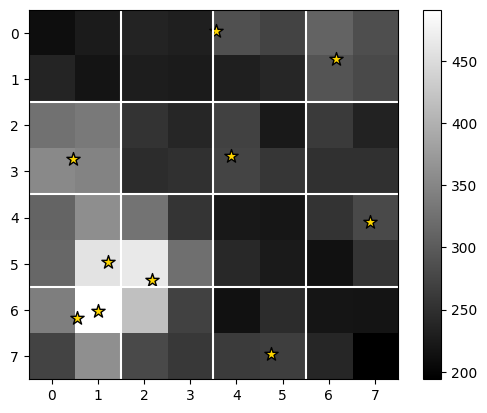

In [2]:
torch.manual_seed(1)

image_dim = 8

true_psf_stdev = 0.93
psf_max = 1 / (2 * np.pi * (true_psf_stdev**2))

true_background = 200

max_objects = 16

true_flux_scale = 5 * np.sqrt(true_background) / psf_max
true_flux_alpha = (-np.log(1 - 0.99)) / (
    np.log(50 * np.sqrt(true_background) / psf_max) - np.log(true_flux_scale)
)

TruePrior = ParetoStarPrior(max_objects = max_objects,
                            image_height = image_dim,
                            image_width = image_dim,
                            flux_scale = true_flux_scale,
                            flux_alpha = true_flux_alpha,
                            pad = 0.25)

TrueImageModel = ImageModel(image_height = image_dim,
                            image_width = image_dim,
                            psf_stdev = true_psf_stdev,
                            background = true_background)

true_counts, true_locs, true_fluxes, images = TrueImageModel.generate(Prior = TruePrior,
                                                                      num_images = 1)

print(f"count\n", true_counts[0].round().item(),
      "\nfluxes\n", true_fluxes[0].round(decimals=1).cpu().numpy(),
      "\nlocs\n", true_locs[0].round(decimals=1).cpu().numpy(), "\n\n")
fig, ax = plt.subplots(1,1)
tmp = ax.imshow(images[0].cpu(), cmap = 'gray')
_ = fig.colorbar(tmp)
_ = ax.scatter(true_locs.squeeze()[:true_counts.squeeze(),1].cpu() - 0.5,
               true_locs.squeeze()[:true_counts.squeeze(),0].cpu() - 0.5,
               marker = '*', color = 'gold', edgecolors = 'black', s = 100)
_ = ax.vlines(x = image_dim//4 - 0.5, ymin = 0 - 0.5, ymax = image_dim - 0.5, color = 'white')
_ = ax.vlines(x = 2*image_dim//4 - 0.5, ymin = 0 - 0.5, ymax = image_dim - 0.5, color = 'white')
_ = ax.vlines(x = 3*image_dim//4 - 0.5, ymin = 0 - 0.5, ymax = image_dim - 0.5, color = 'white')
_ = ax.hlines(y = image_dim//4 - 0.5, xmin = 0 - 0.5, xmax = image_dim - 0.5, color = 'white')
_ = ax.hlines(y = 2*image_dim//4 - 0.5, xmin = 0 - 0.5, xmax = image_dim - 0.5, color = 'white')
_ = ax.hlines(y = 3*image_dim//4 - 0.5, xmin = 0 - 0.5, xmax = image_dim - 0.5, color = 'white')

We will run an SMC sampler to generate catalogs for the entire image (without tiles, for now). We assume that we have access to the true prior and image model. We also specify a Metropolis-Hastings kernel to be used within the SMC sampler.

In [3]:
tile_dim = 8

TilePrior = ParetoStarPrior(max_objects = 14,
                            image_height = tile_dim,
                            image_width = tile_dim,
                            flux_scale = true_flux_scale,
                            flux_alpha = true_flux_alpha,
                            pad = 0.25)

TileImageModel = ImageModel(image_height = tile_dim,
                            image_width = tile_dim,
                            psf_stdev = true_psf_stdev,
                            background = true_background)

MHKernel = SingleComponentMH(max_iters = 100,
                             sqjumpdist_tol = 1e-2,
                             locs_stdev = 0.25,
                             fluxes_stdev = 250,
                             fluxes_min = true_flux_scale,
                             fluxes_max = 1e9)

We initialize an `SMCsampler` and run it on the tiles.

In [4]:
sampler = SMCsampler(image = images[0],
                     tile_dim = tile_dim,
                     Prior = TilePrior,
                     ImageModel = TileImageModel,
                     MutationKernel = MHKernel,
                     num_catalogs_per_count = 1000,
                     ess_threshold_prop = 0.5,
                     resample_method = "multinomial",
                     max_smc_iters = 100,
                     print_every = 2)

print(f"True count: {true_counts[0]}")
print(f"True total observed flux: {images[0].sum()}\n")

sampler.run()

True count: 10
True total observed flux: 17665.0

starting the tile samplers...
iteration 2: temperature in [0.01, 0.01], acceptance rate in [0.61, 0.61]
iteration 4: temperature in [0.02, 0.02], acceptance rate in [0.61, 0.61]
iteration 6: temperature in [0.04, 0.04], acceptance rate in [0.58, 0.58]
iteration 8: temperature in [0.07, 0.07], acceptance rate in [0.52, 0.52]
iteration 10: temperature in [0.13, 0.13], acceptance rate in [0.46, 0.46]
iteration 12: temperature in [0.22, 0.22], acceptance rate in [0.39, 0.39]
iteration 14: temperature in [0.35, 0.35], acceptance rate in [0.33, 0.33]
iteration 16: temperature in [0.56, 0.56], acceptance rate in [0.26, 0.26]
iteration 18: temperature in [0.9, 0.9], acceptance rate in [0.21, 0.21]
done!



We instantiate an `Aggregate` object and resample the catalogs we sampled above. The `Aggregate` object isn't doing much work here at all, but it's helpful when we run our procedure on images partitioned into tiles.

In [5]:
aggMH = SingleComponentMH(max_iters = 100,
                          sqjumpdist_tol = 1e-2,
                          locs_stdev = 0.1,
                          fluxes_stdev = 100,
                          fluxes_min = true_flux_scale,
                          fluxes_max = 1e9)

In [6]:
agg = Aggregate(sampler.Prior,
                sampler.ImageModel,
                aggMH,
                sampler.tiled_image,
                sampler.counts,
                sampler.locs,
                sampler.fluxes,
                sampler.weights_intercount,
                ess_threshold_prop = 0.5,
                resample_method = "multinomial")

agg.run()

aggregating tile catalogs...
done!



We summarize our results by reporting the posterior distribution over the number of stars within the image boundaries and the posterior mean of the total observed flux:

In [7]:
agg.summarize()

summary:
posterior distribution of number of stars:
tensor([ 6,  7,  8,  9, 10, 11, 12, 13])
tensor([0.0020, 0.0330, 0.1920, 0.4270, 0.2930, 0.0470, 0.0060, 0.0000])

posterior mean total flux = 17592.6015625

number of unique catalogs = 3179


We visually examine the posterior distribution of the total observed flux. The dotted black line is the true total observed flux, computed by summing the intensities of all the pixels in the image.

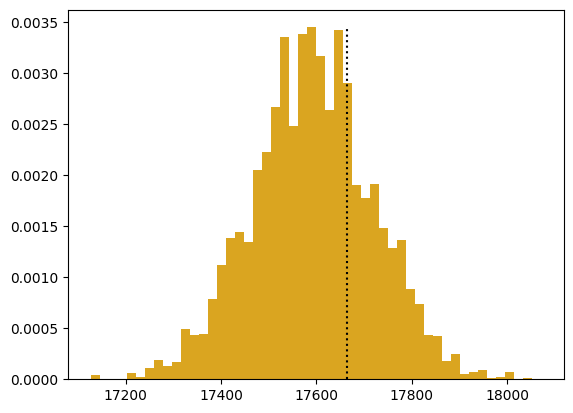

In [8]:
tmp = plt.hist(agg.estimated_total_flux.cpu(), bins = 50, density = True, color = 'goldenrod')
_ = plt.vlines(x = images[0].sum().cpu(), ymin = 0, ymax = tmp[0].max(), color = 'black', linestyle = 'dotted')

We can also reconstruct the image using a few of our posterior samples:

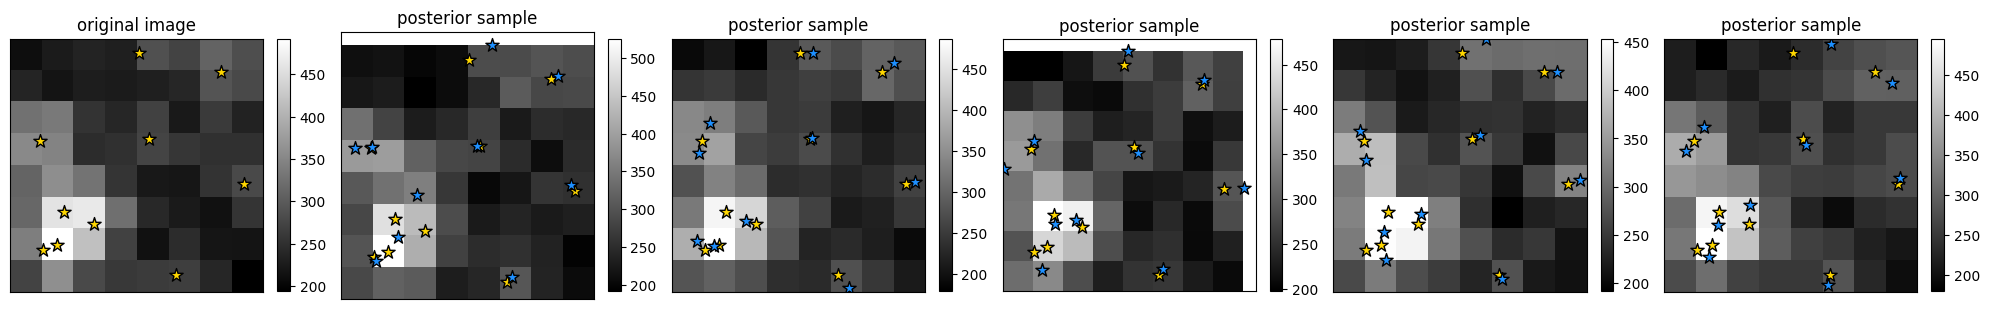

In [9]:
fig, ax = plt.subplots(1, 6, figsize = (20,4))
tmp = ax[0].imshow(images[0].cpu(), cmap = 'gray')
_ = fig.colorbar(tmp, fraction = 0.045)
_ = ax[0].set_title('original image')
_ = ax[0].scatter(true_locs.squeeze()[:true_counts.squeeze(),1].cpu() - 0.5,
                  true_locs.squeeze()[:true_counts.squeeze(),0].cpu() - 0.5,
                  marker = '*', color = 'gold', edgecolors = 'black', s = 100)
_ = ax[0].set_xticks([])
_ = ax[0].set_yticks([])

for j in range(1,6):
    index = torch.randint(low = 0, high = agg.counts.shape[-1] - 1, size = [1])
    psf = agg.ImageModel.psf(agg.locs.detach()[:,:,index])
    rate = (psf * agg.fluxes[:,:,index].unsqueeze(-3).unsqueeze(-4)).sum(-1) + agg.ImageModel.background
    reconstruction = torch.distributions.Poisson(rate).sample().squeeze([0,1]).permute((2,0,1))
    tmp = ax[j].imshow(reconstruction[0].cpu(), cmap = 'gray')
    _ = ax[j].set_title('posterior sample')
    _ = fig.colorbar(tmp, fraction = 0.045)
    _ = ax[j].scatter(true_locs.squeeze()[:true_counts.squeeze(),1].cpu() - 0.5,
                    true_locs.squeeze()[:true_counts.squeeze(),0].cpu() - 0.5,
                    marker = '*', color = 'gold', edgecolors = 'black', s = 100)
    _ = ax[j].scatter(agg.locs.detach().squeeze()[index,:agg.counts.squeeze()[index].int(),1].cpu() - 0.5,
                    agg.locs.detach().squeeze()[index,:agg.counts.squeeze()[index].int(),0].cpu() - 0.5,
                    marker = '*', color = 'dodgerblue', edgecolors = 'black', s = 100)
    _ = ax[j].set_xticks([])
    _ = ax[j].set_yticks([])

fig.tight_layout()

To assess the locations of light sources in our posterior catalogs, we plot a two-dimensional density plot of these locations and overlay them on the image:

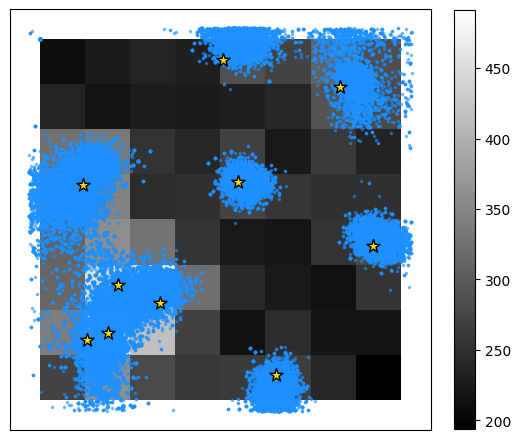

In [10]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
tmp = ax.imshow(images[0].cpu(), cmap = 'gray')
_ = fig.colorbar(tmp, fraction = 0.045)
_ = ax.scatter(agg.locs.detach().squeeze()[...,1].cpu() - 0.5,
               agg.locs.detach().squeeze()[...,0].cpu() - 0.5,
               marker = '.', color = 'dodgerblue', s = 10, alpha = 0.5)
_ = ax.scatter(true_locs.squeeze()[:true_counts.squeeze(),1].cpu() - 0.5,
               true_locs.squeeze()[:true_counts.squeeze(),0].cpu() - 0.5,
               marker = '*', color = 'gold', edgecolors = 'black', s = 100)
_ = ax.set_xticks([])
_ = ax.set_yticks([])

If we only care about stars within the image boundaries, we can "prune" stars outside the boundaries:

In [11]:
c, l, f = agg.prune(agg.locs, agg.fluxes)

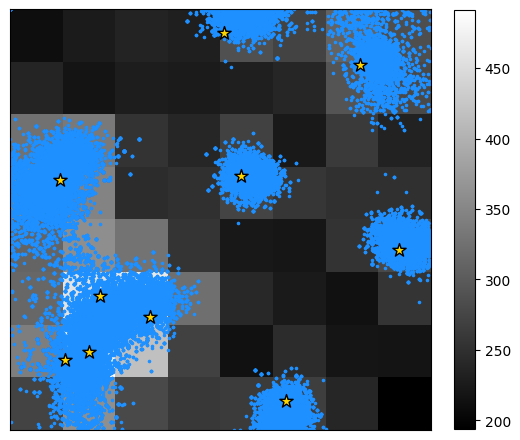

In [12]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
tmp = ax.imshow(images[0].cpu(), cmap = 'gray')
_ = fig.colorbar(tmp, fraction = 0.045)
_ = ax.scatter(l.detach().squeeze()[...,1].cpu() - 0.5,
               l.detach().squeeze()[...,0].cpu() - 0.5,
               marker = '.', color = 'dodgerblue', s = 10, alpha = 1)
_ = ax.scatter(true_locs.squeeze()[:true_counts.squeeze(),1].cpu() - 0.5,
               true_locs.squeeze()[:true_counts.squeeze(),0].cpu() - 0.5,
               marker = '*', color = 'gold', edgecolors = 'black', s = 100)
_ = ax.set_xticks([])
_ = ax.set_yticks([])